In [1]:
import numpy as np
import torch
from scipy import optimize
from sim.cartpole_dc import CartPoleEnv
import csv
from pyswarms.single.global_best import GlobalBestPSO
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import tikzplotlib
from util.io import read_data

In [3]:
states, actions = read_data('data.csv')
states = torch.tensor(states).detach()
actions = torch.tensor([actions]).T.detach()
print(states.shape, actions.shape)

torch.Size([24570, 4]) torch.Size([24570, 1])


In [14]:
def fun(theta, render=False, steps=4):
    env = CartPoleEnv(swingup=True, solver='rk')
    env.mu_cart = theta[0]
    env.Psi = theta[1]
    env.L = theta[2]
    env.J = theta[3]
    env.reset()
    env.state = states[:len(states)-steps]
    env.i = torch.zeros(len(states)-steps)
    for j in range(steps-1):
        env.step(actions[j:len(states)-(steps-j)])
    s, *_ = env.step(actions[steps-1:len(states)-1])
    s = s.numpy()
    env.close()
    return s

In [11]:
def loss_(theta):
    s = fun(theta)
    delta_phi = (states[4:,2] - s[:,2]) % (2 * np.pi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)**2
    return (0.0 * delta_phi + (states[4:,0] - s[:,0])**2).numpy()

def loss(theta):
    losses = []
    for t in theta:
        losses += [np.sum(loss_(t))]
    return losses


In [ ]:
bounds = ([0.001, 0.5, 0.1, 0.01], 
          [0.05, 3.0, 0.5, 0.1])
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=50, dimensions=4, options=options, bounds=bounds)
cost, pos = optimizer.optimize(loss, 100)

2020-04-20 18:23:25,809 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

pyswarms.single.global_best:   0%|          |0/100
pyswarms.single.global_best:   0%|          |0/100, best_cost=2.96
pyswarms.single.global_best:   1%|          |1/100, best_cost=2.96
pyswarms.single.global_best:   1%|          |1/100, best_cost=2.96
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.96
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=2.96
pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.96
pyswarms.single.global_best:   3%|▎         |3/100, best_cost=2.96
pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.96
pyswarms.single.global_best:   4%|▍         |4/100, best_cost=2.96
pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.96
pyswarms.single.global_best:   5%|▌         |5/100, best_cost=2.96
pyswarms.single.global_best:   6%|▌         |6/100, best_cost=2.96
pyswarms.single.glob

[0.01396206 0.01352168 1.99035116 0.42467046 0.04404707]


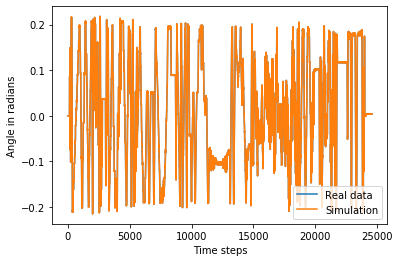

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


0.44323838


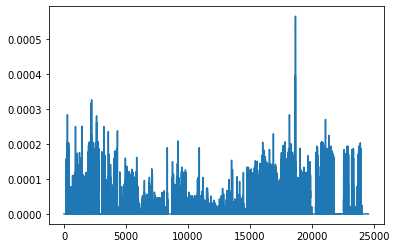

In [115]:
print(pos)
s = fun(pos)

plt.figure()
a, = plt.plot(states[:,0], label='Real data')
b, = plt.plot(s[:,0], label='Simulation')
plt.xlabel('Time steps')
plt.ylabel('Angle in radians')
plt.legend(handles=[a,b])
tikzplotlib.save("polefit.tex")
plt.show()

plt.figure()
plt.plot(loss_(pos))
print(np.sum(loss_(pos)))

In [49]:
optimize.least_squares(loss_, pos, bounds=bounds)

 active_mask: array([0, 0, 0, 0, 0])
        cost: 0.011053385213017464
         fun: array([2.2737371e-14, 2.2737371e-14, 2.2737371e-14, ..., 3.8595318e-09,
       3.8595318e-09, 3.8595318e-09], dtype=float32)
        grad: array([-0.00391693,  0.        ,  0.02159393,  0.01855953, -0.01856432])
         jac: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 19
        njev: 8
  optimality: 0.030112236070514414
      status: 3
     success: True
           x: array([2.26273920e-01, 7.77691616e-01, 1.40447706e+00, 1.35050072e-03,
       1.65104690e-02])